# Agenda
1. Loading Data 
2. Pre-processing
3. Building a Multi-Layer Perceptron
4. Loss Function and Optimizer
5. Training the model
6. Tensorboard
7. Building a CNN
8. Optimization Techniques
9. Prediction

# Loading Libraries

In [1]:
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt 
import cv2
import os

# Loading Dataset

In [2]:
train_data_path = '/Users/danieljerman/Desktop/Data/train/'
test_data_path = '/Users/danieljerman/Desktop/Data/test/'
test_data_file = '/Users/danieljerman/Desktop/Data/Testing_set_animals.csv'

In [3]:
X_train_set = []
y_train_set = []
exceptions = 0
for label in os.listdir(train_data_path):
#for label in [os.listdir(train_data_path)[0]]:
    for arch in os.listdir(train_data_path+label):
        try:
            img = cv2.imread(train_data_path+label+'/'+arch)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            X_train_set.append(img)
            y_train_set.append(label)
        except:
            exceptions = exceptions + 1

In [4]:
print('Number of images for training: ' + str(len(X_train_set)))
print('Number of labels: ' + str(len(os.listdir(train_data_path))))
print('Number of exceptions: ' + str(exceptions))

Number of images for training: 8196
Number of labels: 5
Number of exceptions: 2


In [5]:
from sklearn.utils import shuffle
X_train_set, y_train_set = shuffle(X_train_set, y_train_set, random_state=2048)

In [6]:
X_test_set = []
exceptions = 0
test_source_images = pd.read_csv(test_data_file)
test_source_images.drop(columns='target', inplace=True)
for img in test_source_images.filename:
    try:
        img = cv2.imread(test_data_path+img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        X_test_set.append(img)
    except:
        exceptions = exceptions + 1

In [7]:
print('Number of images for test: ' + str(len(X_test_set)))
print('Number of exceptions: ' + str(exceptions))

Number of images for test: 910
Number of exceptions: 0


Display Traing Data

Image shape: (166, 280, 3)
Label: scoiattolo_train


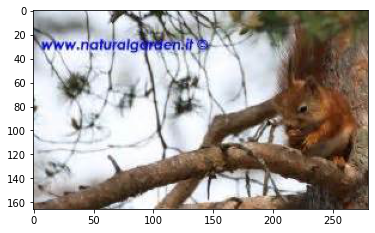

In [8]:
plt.imshow(X_train_set[0])
print('Image shape: ' + str(X_train_set[0].shape))
print('Label: ' + str(y_train_set[0]))

Display Test Data

Image shape: (640, 426, 3)


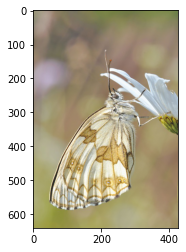

In [9]:
plt.imshow(X_test_set[0])
print('Image shape: ' + str(X_test_set[0].shape))

# Preprocessing

Check Image Shape

In [10]:
shapes = [x.shape for x in X_train_set]

In [11]:
shapes[:5]

[(166, 280, 3), (200, 300, 3), (200, 300, 3), (426, 640, 3), (200, 300, 3)]

## Scaling
Get all images of same size in order to get same amount of data, and consequently, same shape for each image. The code makes possible to get the greyscale of images.

In [12]:
def resize_image_array(img, img_size_dims, grey=None):
    if grey:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.resize(img, dsize=img_size_dims, interpolation=cv2.INTER_CUBIC)#cv2.INTER_CUBIC
    #img = np.array(img, dtype=np.float32)
    return img

In [13]:
IMG_DIMS = (128, 128)

X_train_set_reshaped = np.array([resize_image_array(img, img_size_dims=IMG_DIMS, grey=None) for img in X_train_set])
X_test_set_reshaped = np.array([resize_image_array(img, img_size_dims=IMG_DIMS, grey=None) for img in X_test_set]) 

Image shape: (128, 128, 3)
Label: scoiattolo_train


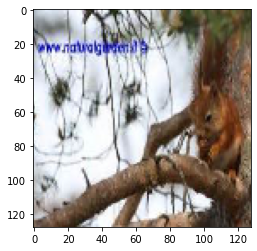

In [14]:
plt.imshow(X_train_set_reshaped[0])
print('Image shape: ' + str(X_train_set_reshaped[0].shape))
print('Label: ' +str(y_train_set[0]))

## Normalization
For faster convergency of the NN

In [15]:
X_train_set_norm = X_train_set_reshaped / 255
X_test_set_norm = X_test_set_reshaped / 255

In [16]:
print(X_train_set_norm.shape)
print(X_test_set_norm.shape)

(8196, 128, 128, 3)
(910, 128, 128, 3)


# Multilayer Perceptron

## Flatten the Data
To get the right shape for input layer

In [17]:
shape = IMG_DIMS[0]*IMG_DIMS[0] * 3
X_train_flattened = X_train_set_norm.reshape(len(X_train_set_norm), shape)
X_test_flattened = X_test_set_norm.reshape(len(X_test_set_norm), shape)

In [18]:
y_train_set = np.array(y_train_set)

In [19]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(np.unique(y_train_set))
y_train_set_transformed = (le.transform(y_train_set))

In [20]:
y_train_set_transformed = y_train_set_transformed.reshape(y_train_set_transformed.shape[0],1)

In [21]:
print(X_train_flattened.shape)
print(y_train_set_transformed.shape)

(8196, 49152)
(8196, 1)


## Model Definition

In [22]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import Sequential 
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense

In [23]:
# Defining the Model
model = tf.keras.models.Sequential()
# input layer
model.add(tf.keras.layers.Dense(1024, input_shape=(shape,), activation='relu'))
model.add(tf.keras.layers.Dense(512, activation='relu'))
# output layer
model.add(tf.keras.layers.Dense(5, activation='softmax'))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              50332672  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 2565      
Total params: 50,860,037
Trainable params: 50,860,037
Non-trainable params: 0
_________________________________________________________________


The model has 3 layers: one hidden and one output layer. The activation function of the input and hidden layer is Relu, as it is the suitable for that, and the output layer is a 5 neurons (5 labels of images) with a softmax activation functions which is used for multiclass classification problems. Remember thar sigmoid is used for classification, but binary problems.

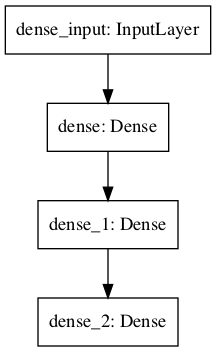

In [25]:
from tensorflow.keras.utils import plot_model
plot_model(model)

Model compile

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

The optimizer selected for the problem is Adam which is an extension to stochastic gradient descent that has recently seen broader adoption for deep learning applications in computer vision and natural language processing. So as it is the most used accross the community, I started with Adam. 

The loss function is sparse categorical crossentropy as the problem is a multiclass classification problem.

The metric for measuring the result is accuracy, as I want to get the percentage of good classified images.

Fit the Model

In [27]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, 
                                               restore_best_weights=True,
                                               verbose=1)

history = model.fit(X_train_flattened, 
                    y_train_set_transformed, 
                    batch_size = 128, 
                    callbacks=[es_callback],
                    validation_split=0.2, 
                    epochs=100, 
                    verbose = 1)

Train on 6556 samples, validate on 1640 samples
Epoch 1/100
6556/6556 [==============================] - 61s 9ms/sample - loss: 1.5436 - acc: 0.3203 - val_loss: 1.4076 - val_acc: 0.3799
Epoch 2/100
6556/6556 [==============================] - 51s 8ms/sample - loss: 1.3669 - acc: 0.4237 - val_loss: 1.3944 - val_acc: 0.4134
Epoch 3/100
6556/6556 [==============================] - 46s 7ms/sample - loss: 1.2993 - acc: 0.4700 - val_loss: 1.3009 - val_acc: 0.4762
Epoch 4/100
6556/6556 [==============================] - 46s 7ms/sample - loss: 1.2232 - acc: 0.5146 - val_loss: 1.3304 - val_acc: 0.4616
Epoch 5/100
6556/6556 [==============================] - 46s 7ms/sample - loss: 1.1923 - acc: 0.5212 - val_loss: 1.2722 - val_acc: 0.4921
Epoch 6/100
6556/6556 [==============================] - 46s 7ms/sample - loss: 1.1794 - acc: 0.5348 - val_loss: 1.2437 - val_acc: 0.5061
Epoch 7/100
6556/6556 [==============================] - 48s 7ms/sample - loss: 1.1421 - acc: 0.5480 - val_loss: 1.2660 - va

I decide to get 100 epochs for the training, however I used an early stopping with patience of 2 in val_loss in order not to get more epochs with poor results.

With the validation_split I assure the 80:20 ratio asked in the guidelines.

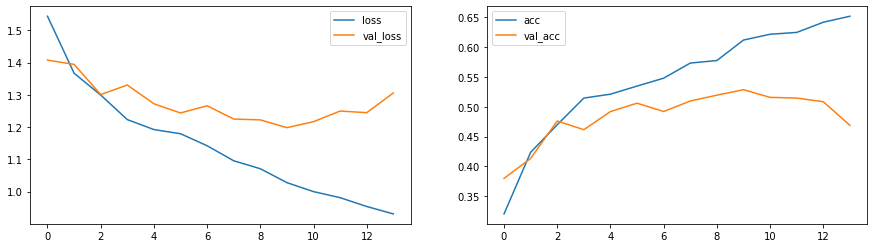

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['acc', 'val_acc']].plot(kind='line', ax=ax[1]);

Graph displaying loss and accuracy both in train and validation

In [29]:
prediction_labels_train = np.argmax(model.predict(X_train_flattened), axis=1)
prediction_labels_train = le.inverse_transform(prediction_labels_train)
np.unique(prediction_labels_train)

array(['elefante_train', 'farfalla_train', 'mucca_train', 'pecora_train',
       'scoiattolo_train'], dtype='<U16')

Checking if predictions on train set display all the classes, just for be sure is working

# Predictions with MLP

In [39]:
prediction_labels_test = np.argmax(model.predict(X_test_flattened), axis=1)
prediction_labels_test = le.inverse_transform(prediction_labels_test)
np.unique(prediction_labels_test)

array(['farfalla_train', 'mucca_train', 'scoiattolo_train'], dtype='<U16')

In [42]:
predictions = [x.split('_')[0] for x in prediction_labels_test]

In [44]:
np.savetxt('/Users/danieljerman/Desktop/data/prediction_mlp.csv', predictions, delimiter=',', fmt='%s')

# CNN

Data

In [26]:
print(X_train_set_norm.shape)
print(y_train_set_transformed.shape)
print(X_test_set_norm.shape)

(8196, 128, 128, 3)
(8196, 1)
(910, 128, 128, 3)


In [27]:
INPUT_SHAPE = (128, 128, 3)

model = tf.keras.models.Sequential()
# define conv-pool layers - set 1
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# define conv-pool layers - set 2
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# add flatten layer
model.add(tf.keras.layers.Flatten())

# add dense layers
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(256, activation='relu'))

# add output layer
model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28800)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               7373056   
_________________________________________________________________
dense_4 (Dense)              (None, 256)              

In [55]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

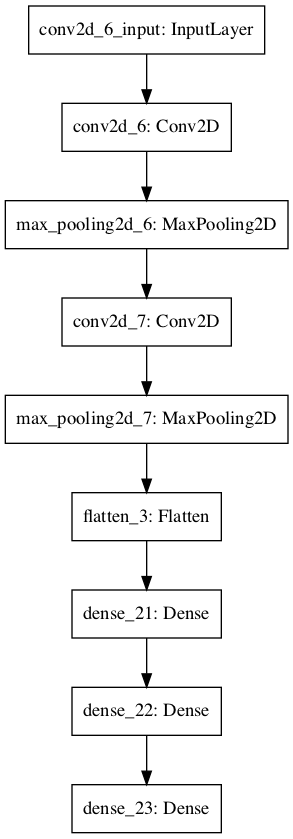

In [56]:
plot_model(model)

Layers early in the network architecture learn fewer convolutional filters while layers deeper in the network will learn more filters. That's why I chose 2 Conv2D layers, the first with 16 filters and the next one with 32. The Max pooling layer is used to reduce the spatial dimensions of the output volume. 

The kernel_size used was a 3x3 as it is common for images of the shape we are using.

The strides parameter was set as the default (1, 1).

With the valid option in the padding parameter the input volume is not zero-padded and the spatial dimensions are allowed to reduce via the natural application of convolution.

After convolutions and polling layers, I add a Flatten layer to be the step befor th dense layers for starting the classification process.

As in the MLP NN, the activation functions in the convolutional and hidden layers are Relu, and the activation function iun the output layers is SoftMax.

In [58]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, 
                                               restore_best_weights=True,
                                               verbose=1)

history = model.fit(X_train_set_norm, 
                    y_train_set_transformed, 
                    batch_size = 128, 
                    callbacks=[es_callback],
                    validation_split=0.2, 
                    epochs=100, 
                    verbose = 1)

Train on 6556 samples, validate on 1640 samples
Epoch 1/100
6556/6556 [==============================] - 38s 6ms/sample - loss: 1.5301 - acc: 0.3344 - val_loss: 1.4585 - val_acc: 0.3774
Epoch 2/100
6556/6556 [==============================] - 24s 4ms/sample - loss: 1.3965 - acc: 0.4309 - val_loss: 1.3489 - val_acc: 0.4780
Epoch 3/100
6556/6556 [==============================] - 28s 4ms/sample - loss: 1.2811 - acc: 0.4977 - val_loss: 1.2531 - val_acc: 0.5268
Epoch 4/100
6556/6556 [==============================] - 24s 4ms/sample - loss: 1.1857 - acc: 0.5395 - val_loss: 1.1725 - val_acc: 0.5409
Epoch 5/100
6556/6556 [==============================] - 25s 4ms/sample - loss: 1.1168 - acc: 0.5636 - val_loss: 1.1066 - val_acc: 0.5823
Epoch 6/100
6556/6556 [==============================] - 24s 4ms/sample - loss: 1.0679 - acc: 0.5857 - val_loss: 1.0942 - val_acc: 0.5799
Epoch 7/100
6556/6556 [==============================] - 24s 4ms/sample - loss: 1.0272 - acc: 0.6007 - val_loss: 1.0417 - va

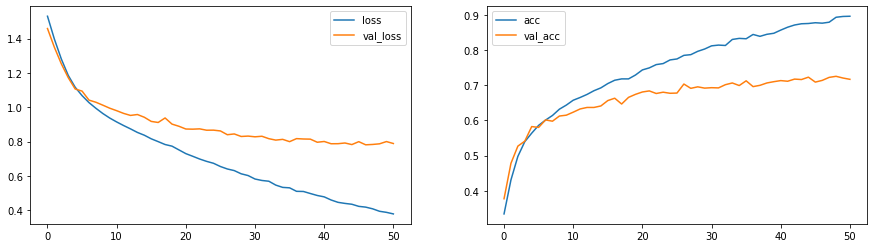

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['acc', 'val_acc']].plot(kind='line', ax=ax[1]);

Clearly, the NN overfitted to the training set, as the loss in training get lower the loss in validation diminished got flattened. Same happens with accuracy.

# Optimization

## CNN Adding L2 regularization and a Dropout Layer

In [28]:
import datetime
%load_ext tensorboard
log_dir = '/Users/danieljerman/Desktop/data/tensorboard' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [28]:
print(X_train_set_norm.shape)
print(y_train_set_transformed.shape)
print(X_test_set_norm.shape)

(8196, 128, 128, 3)
(8196, 1)
(910, 128, 128, 3)


In [31]:
INPUT_SHAPE = (128, 128, 3)

model = tf.keras.models.Sequential()
# define conv-pool layers - set 1
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# define conv-pool layers - set 2
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# add flatten layer
model.add(tf.keras.layers.Flatten())

# add dense layers with some dropout
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer = 'l2'))
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer = 'l2'))
model.add(tf.keras.layers.Dropout(rate=0.2))
# add output layer
model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28800)             0         
_________________________________________________________________
dropout (Dropout)            (None, 28800)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)              

In [32]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

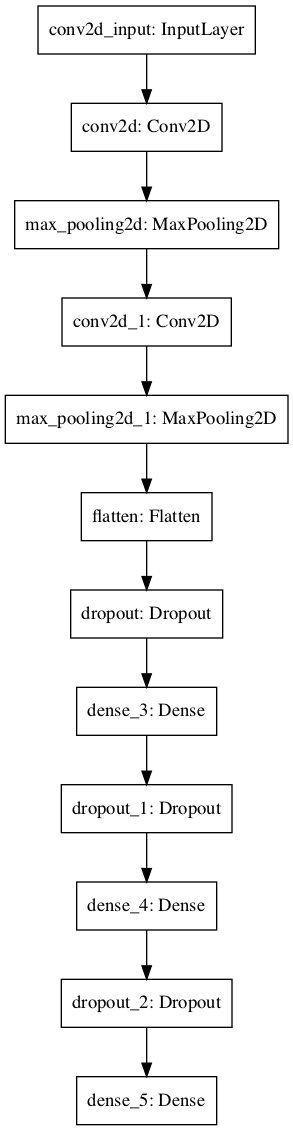

In [33]:
plot_model(model)

In [34]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, 
                                               restore_best_weights=True,
                                               verbose=1)

history = model.fit(X_train_set_norm, 
                    y_train_set_transformed, 
                    batch_size = 128, 
                    callbacks=[tensorboard_callback, es_callback],
                    validation_split=0.2, 
                    epochs=100, 
                    verbose = 1)

Train on 6556 samples, validate on 1640 samples
Epoch 1/100
6556/6556 [==============================] - 89s 14ms/sample - loss: 8.8190 - acc: 0.2701 - val_loss: 8.3695 - val_acc: 0.3622
Epoch 2/100
6556/6556 [==============================] - 63s 10ms/sample - loss: 8.0202 - acc: 0.3455 - val_loss: 7.6294 - val_acc: 0.4055
Epoch 3/100
6556/6556 [==============================] - 60s 9ms/sample - loss: 7.3357 - acc: 0.3922 - val_loss: 7.0014 - val_acc: 0.4573
Epoch 4/100
6556/6556 [==============================] - 60s 9ms/sample - loss: 6.7633 - acc: 0.4397 - val_loss: 6.4782 - val_acc: 0.4799
Epoch 5/100
6556/6556 [==============================] - 60s 9ms/sample - loss: 6.2782 - acc: 0.4655 - val_loss: 6.0270 - val_acc: 0.5244
Epoch 6/100
6556/6556 [==============================] - 66s 10ms/sample - loss: 5.8685 - acc: 0.4979 - val_loss: 5.6478 - val_acc: 0.5317
Epoch 7/100
6556/6556 [==============================] - 61s 9ms/sample - loss: 5.5158 - acc: 0.5265 - val_loss: 5.3308 -

As seen that acc of train and validation has some difference, we can see deduce that the model is overfitting de train, but less than the previous model without regularization. So, to solve that, I will try to add a little bit more of regularization, and while we get acc of 0.83 we still have some bias with the data so I will add one more layer too.

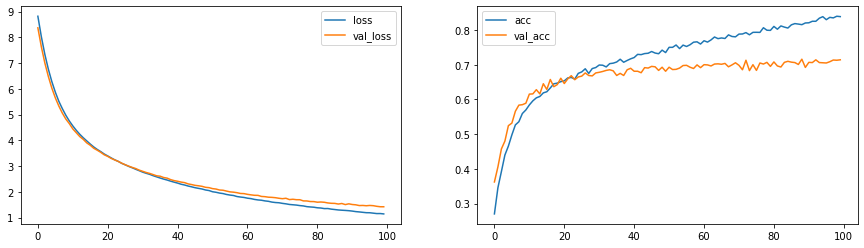

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['acc', 'val_acc']].plot(kind='line', ax=ax[1]);

In [36]:
%tensorboard --logdir logs/fit

As seen that acc of train and validation has some difference, we can see deduce that the model is overfitting de train, but less than the previous model without regularization. So, to solve that, I will try to add a little bit more of regularization, and while we get acc of 0.83 we still have some bias with the data so I will add one more layer too.

In [29]:
INPUT_SHAPE = (128, 128, 3)

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# add flatten layer
model.add(tf.keras.layers.Flatten())

# add dense layers
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(512, activation='relu', kernel_regularizer = 'l2'))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer = 'l2'))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(512, activation='relu', kernel_regularizer = 'l2'))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer = 'l2'))
model.add(tf.keras.layers.Dropout(rate=0.3))
# add output layer
model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, 
                                               restore_best_weights=True,
                                               verbose=1)

history = model.fit(X_train_set_norm, 
                    y_train_set_transformed, 
                    batch_size = 128, 
                    callbacks=[tensorboard_callback, es_callback],
                    validation_split=0.2, 
                    epochs=100, 
                    verbose = 1)

Train on 6556 samples, validate on 1640 samples
Epoch 1/100
6556/6556 [==============================] - 179s 27ms/sample - loss: 27.5541 - acc: 0.2230 - val_loss: 26.2215 - val_acc: 0.3268
Epoch 2/100
6556/6556 [==============================] - 159s 24ms/sample - loss: 25.1231 - acc: 0.2596 - val_loss: 23.9628 - val_acc: 0.3220
Epoch 3/100
6556/6556 [==============================] - 151s 23ms/sample - loss: 23.0371 - acc: 0.2971 - val_loss: 22.0451 - val_acc: 0.3384
Epoch 4/100
6556/6556 [==============================] - 154s 23ms/sample - loss: 21.2679 - acc: 0.3333 - val_loss: 20.4044 - val_acc: 0.3805
Epoch 5/100
6556/6556 [==============================] - 153s 23ms/sample - loss: 19.7677 - acc: 0.3650 - val_loss: 18.9970 - val_acc: 0.4445
Epoch 6/100
6556/6556 [==============================] - 152s 23ms/sample - loss: 18.4675 - acc: 0.4187 - val_loss: 17.8076 - val_acc: 0.4890
Epoch 7/100
6556/6556 [==============================] - 153s 23ms/sample - loss: 17.3636 - acc: 0.4

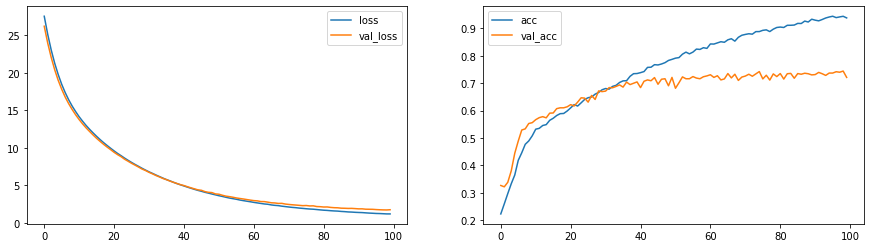

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['acc', 'val_acc']].plot(kind='line', ax=ax[1]);

Still having variance problems. Lets try one more time.

In [28]:
INPUT_SHAPE = (128, 128, 3)

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# add flatten layer
model.add(tf.keras.layers.Flatten())

# add dense layers
model.add(tf.keras.layers.Dropout(rate=0.4))
model.add(tf.keras.layers.Dense(512, activation='relu', kernel_regularizer = 'l2'))
model.add(tf.keras.layers.Dropout(rate=0.4))
model.add(tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer = 'l2'))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(512, activation='relu', kernel_regularizer = 'l2'))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer = 'l2'))
model.add(tf.keras.layers.Dropout(rate=0.3))
# add output layer
model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, 
                                               restore_best_weights=True,
                                               verbose=1)

history = model.fit(X_train_set_norm, 
                    y_train_set_transformed, 
                    batch_size = 128, 
                    callbacks=[tensorboard_callback, es_callback],
                    validation_split=0.2, 
                    epochs=1000, 
                    verbose = 1)

Train on 6556 samples, validate on 1640 samples
Epoch 1/1000
6556/6556 [==============================] - 81s 12ms/sample - loss: 27.7206 - acc: 0.2041 - val_loss: 26.8523 - val_acc: 0.2341
Epoch 2/1000
6556/6556 [==============================] - 64s 10ms/sample - loss: 26.1086 - acc: 0.2248 - val_loss: 25.3034 - val_acc: 0.2341
Epoch 3/1000
6556/6556 [==============================] - 62s 10ms/sample - loss: 24.6086 - acc: 0.2357 - val_loss: 23.8629 - val_acc: 0.2341
Epoch 4/1000
6556/6556 [==============================] - 63s 10ms/sample - loss: 23.2217 - acc: 0.2318 - val_loss: 22.5262 - val_acc: 0.2409
Epoch 5/1000
6556/6556 [==============================] - 63s 10ms/sample - loss: 21.9323 - acc: 0.2357 - val_loss: 21.2834 - val_acc: 0.2561
Epoch 6/1000
6556/6556 [==============================] - 63s 10ms/sample - loss: 20.7329 - acc: 0.2569 - val_loss: 20.1274 - val_acc: 0.2585
Epoch 7/1000
6556/6556 [==============================] - 66s 10ms/sample - loss: 19.6168 - acc: 0.2

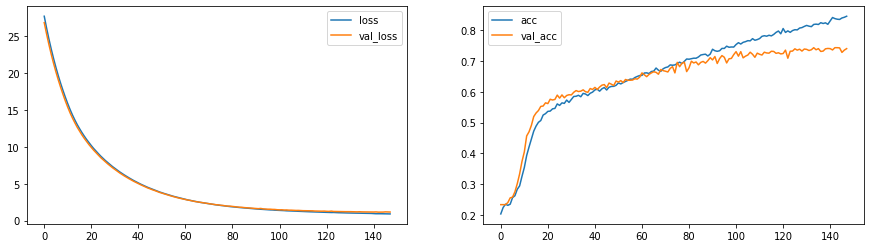

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['acc', 'val_acc']].plot(kind='line', ax=ax[1]);

# Predictions with CNN & Regularization

In [30]:
prediction_labels_test = np.argmax(model.predict(X_test_set_norm), axis=1)
prediction_labels_test = le.inverse_transform(prediction_labels_test)
predictions = [x.split('_')[0] for x in prediction_labels_test]
np.unique(predictions)

array(['elefante', 'farfalla', 'mucca', 'pecora', 'scoiattolo'],
      dtype='<U10')

In [31]:
np.savetxt('/Users/danieljerman/Desktop/data/prediction_cnn_reg.csv', predictions, delimiter=',', fmt='%s')

In [32]:
model.save('/Users/danieljerman/Desktop/data/cnn_reg_model')

In [33]:
print(predictions)

['scoiattolo', 'farfalla', 'farfalla', 'farfalla', 'farfalla', 'scoiattolo', 'elefante', 'pecora', 'pecora', 'elefante', 'pecora', 'elefante', 'elefante', 'scoiattolo', 'scoiattolo', 'farfalla', 'elefante', 'mucca', 'pecora', 'mucca', 'scoiattolo', 'elefante', 'scoiattolo', 'scoiattolo', 'scoiattolo', 'pecora', 'elefante', 'farfalla', 'farfalla', 'farfalla', 'pecora', 'pecora', 'pecora', 'pecora', 'pecora', 'pecora', 'elefante', 'farfalla', 'mucca', 'farfalla', 'farfalla', 'mucca', 'farfalla', 'pecora', 'pecora', 'elefante', 'elefante', 'scoiattolo', 'elefante', 'elefante', 'elefante', 'farfalla', 'farfalla', 'farfalla', 'pecora', 'farfalla', 'farfalla', 'mucca', 'farfalla', 'farfalla', 'pecora', 'farfalla', 'farfalla', 'farfalla', 'mucca', 'pecora', 'pecora', 'farfalla', 'farfalla', 'mucca', 'farfalla', 'farfalla', 'pecora', 'pecora', 'pecora', 'farfalla', 'mucca', 'scoiattolo', 'farfalla', 'farfalla', 'farfalla', 'farfalla', 'farfalla', 'elefante', 'farfalla', 'farfalla', 'pecora', '

## MLP Adding L2 regularization and a Dropout Layer

## Flatten the Data
To get the right shape for input layer

In [35]:
shape = IMG_DIMS[0]*IMG_DIMS[0] * 3
X_train_flattened = X_train_set_norm.reshape(len(X_train_set_norm), shape)
X_test_flattened = X_test_set_norm.reshape(len(X_test_set_norm), shape)

In [36]:
y_train_set = np.array(y_train_set)

In [37]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(np.unique(y_train_set))
y_train_set_transformed = (le.transform(y_train_set))

In [38]:
y_train_set_transformed = y_train_set_transformed.reshape(y_train_set_transformed.shape[0],1)

In [39]:
print(X_train_flattened.shape)
print(y_train_set_transformed.shape)

(8196, 49152)
(8196, 1)


## Model Definition

In [40]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import Sequential 
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense

In [41]:
# Defining the Model
model = tf.keras.models.Sequential()
# input layer
model.add(tf.keras.layers.Dense(1024, input_shape=(shape,), activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.Dense(512, activation='relu', kernel_regularizer = 'l2'))
model.add(tf.keras.layers.Dropout(rate=0.2))
# output layer
model.add(tf.keras.layers.Dense(5, activation='softmax'))


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, 
                                               restore_best_weights=True,
                                               verbose=1)

history = model.fit(X_train_flattened, 
                    y_train_set_transformed, 
                    batch_size = 128, 
                    callbacks=[es_callback],
                    validation_split=0.2, 
                    epochs=100, 
                    verbose = 1)

Train on 6556 samples, validate on 1640 samples
Epoch 1/100
6556/6556 [==============================] - 69s 11ms/sample - loss: 8.3335 - acc: 0.2936 - val_loss: 8.0651 - val_acc: 0.3793
Epoch 2/100
6556/6556 [==============================] - 51s 8ms/sample - loss: 7.9736 - acc: 0.3612 - val_loss: 7.7921 - val_acc: 0.4256
Epoch 3/100
6556/6556 [==============================] - 47s 7ms/sample - loss: 7.6768 - acc: 0.3970 - val_loss: 7.5428 - val_acc: 0.4061
Epoch 4/100
6556/6556 [==============================] - 47s 7ms/sample - loss: 7.4276 - acc: 0.4289 - val_loss: 7.2892 - val_acc: 0.4445
Epoch 5/100
6556/6556 [==============================] - 47s 7ms/sample - loss: 7.1823 - acc: 0.4413 - val_loss: 7.0896 - val_acc: 0.4476
Epoch 6/100
6556/6556 [==============================] - 47s 7ms/sample - loss: 6.9483 - acc: 0.4675 - val_loss: 6.8432 - val_acc: 0.4689
Epoch 7/100
6556/6556 [==============================] - 47s 7ms/sample - loss: 6.7363 - acc: 0.4728 - val_loss: 6.6546 - v

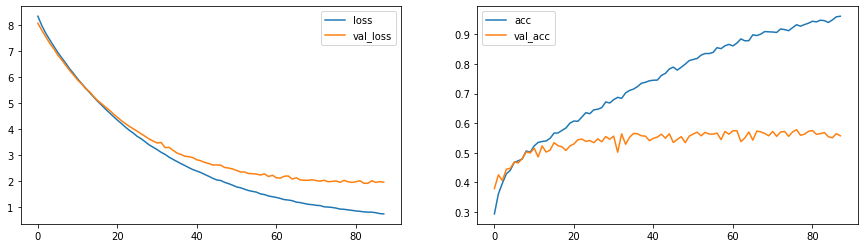

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['acc', 'val_acc']].plot(kind='line', ax=ax[1]);

As we can see, regularization helps to avoid overfitting as we can now run more epochs and still getting a lower validation loss. However, it does not solve all the problem, as the train set finally get a best fit than validation set.

# Final Shot: Data augmentation

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_set_norm, y_train_set_transformed, test_size=0.2, random_state=12, stratify=y_train_set_transformed)

In [30]:
for i in range(0,5):
    print(np.count_nonzero(y_train == i, axis = 0)[0]/y_train.shape[0])
    print(np.count_nonzero(y_test == i, axis = 0)[0]/y_test.shape[0])

0.15878584502745577
0.15853658536585366
0.23184868822452714
0.23231707317073172
0.20500305064063454
0.2048780487804878
0.199816961561928
0.2
0.20454545454545456
0.20426829268292682


In [31]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
    ]
)

In [32]:
augmented_x = data_augmentation(X_train)
augmented_x = np.concatenate((X_train, augmented_x.numpy()))
augmented_y = np.concatenate((y_train, y_train))


augmented_x2 = data_augmentation(X_train)
augmented_x = np.concatenate((augmented_x, augmented_x2.numpy()))
augmented_y = np.concatenate((augmented_y, y_train))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [33]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(augmented_x, augmented_y, random_state=2048)

In [34]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(19668, 128, 128, 3)
(19668, 1)
(1640, 128, 128, 3)
(1640, 1)


In [44]:
INPUT_SHAPE = (128, 128, 3)

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# add flatten layer
model.add(tf.keras.layers.Flatten())

# add dense layers
model.add(tf.keras.layers.Dropout(rate=0.4))
model.add(tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer = 'l2'))
model.add(tf.keras.layers.Dropout(rate=0.4))
model.add(tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer = 'l2'))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(512, activation='relu', kernel_regularizer = 'l2'))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(512, activation='relu', kernel_regularizer = 'l2'))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(512, activation='relu', kernel_regularizer = 'l2'))
model.add(tf.keras.layers.Dropout(rate=0.3))
# add output layer
model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, 
                                               restore_best_weights=True,
                                               verbose=1)

history = model.fit(X_train,
                    y_train,
                    batch_size = 64, 
                    callbacks=[es_callback],
                    validation_data=(X_test, y_test), 
                    epochs=300, 
                    verbose = 1)

Epoch 1/300
308/308 [==============================] - 176s 567ms/step - loss: 43.2567 - accuracy: 0.2283 - val_loss: 31.6416 - val_accuracy: 0.2323
Epoch 2/300
308/308 [==============================] - 168s 544ms/step - loss: 28.8064 - accuracy: 0.2362 - val_loss: 21.6367 - val_accuracy: 0.2335
Epoch 3/300
308/308 [==============================] - 162s 525ms/step - loss: 19.8632 - accuracy: 0.2459 - val_loss: 15.2540 - val_accuracy: 0.3299
Epoch 4/300
308/308 [==============================] - 161s 522ms/step - loss: 14.1397 - accuracy: 0.3573 - val_loss: 11.1700 - val_accuracy: 0.4110
Epoch 5/300
308/308 [==============================] - 162s 526ms/step - loss: 10.4838 - accuracy: 0.4122 - val_loss: 8.5231 - val_accuracy: 0.4384
Epoch 6/300
308/308 [==============================] - 164s 532ms/step - loss: 8.0600 - accuracy: 0.4423 - val_loss: 6.6440 - val_accuracy: 0.4884
Epoch 7/300
308/308 [==============================] - 162s 525ms/step - loss: 6.3382 - accuracy: 0.4722 - va

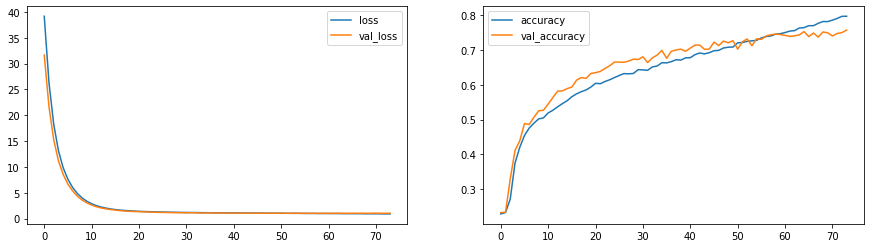

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

# Predictions with CNN & Regularization

In [46]:
prediction_labels_test = np.argmax(model.predict(X_test_set_norm), axis=1)
prediction_labels_test = le.inverse_transform(prediction_labels_test)
predictions = [x.split('_')[0] for x in prediction_labels_test]
np.unique(predictions)

array(['elefante', 'farfalla', 'mucca', 'pecora', 'scoiattolo'],
      dtype='<U10')

In [47]:
np.savetxt('/Users/danieljerman/Desktop/data/prediction_cnn_reg.csv', predictions, delimiter=',', fmt='%s')

In [48]:
print(predictions)

['farfalla', 'farfalla', 'farfalla', 'farfalla', 'farfalla', 'farfalla', 'elefante', 'pecora', 'scoiattolo', 'pecora', 'pecora', 'elefante', 'elefante', 'scoiattolo', 'scoiattolo', 'farfalla', 'scoiattolo', 'pecora', 'pecora', 'pecora', 'scoiattolo', 'elefante', 'pecora', 'pecora', 'scoiattolo', 'scoiattolo', 'elefante', 'farfalla', 'farfalla', 'farfalla', 'pecora', 'pecora', 'pecora', 'pecora', 'scoiattolo', 'pecora', 'scoiattolo', 'farfalla', 'elefante', 'farfalla', 'farfalla', 'pecora', 'farfalla', 'pecora', 'pecora', 'elefante', 'elefante', 'elefante', 'elefante', 'elefante', 'elefante', 'farfalla', 'farfalla', 'farfalla', 'pecora', 'farfalla', 'farfalla', 'elefante', 'farfalla', 'farfalla', 'scoiattolo', 'farfalla', 'farfalla', 'farfalla', 'mucca', 'pecora', 'pecora', 'scoiattolo', 'farfalla', 'mucca', 'farfalla', 'farfalla', 'pecora', 'pecora', 'pecora', 'farfalla', 'pecora', 'scoiattolo', 'farfalla', 'farfalla', 'farfalla', 'farfalla', 'farfalla', 'elefante', 'farfalla', 'farfal